In [1]:
import pandas as pd
import re
import os
import numpy as np
import librosa
import soundfile as sf
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
CONFIG_FILE_PATH = r"D:\Datasets\config_paths.csv"
CONFIG_df = pd.read_csv(CONFIG_FILE_PATH).dropna()
paths = []
for index, row in CONFIG_df.iterrows():
    paths.append(row["path"].replace("\\", "/"))
CONFIG_df["path"] = paths
del paths, index, row

In [3]:
CONFIG_df

,data,path
0,Neurovoz_METADATA_FILE,D:/Datasets/Neurovoz_v3/data/metadata/metadata...
1,Neurovoz_AUDIO_FOLDER,D:/Datasets/Neurovoz_v3/data/audios
2,Neurovoz_BASE_PATH,D:/Datasets/Neurovoz_v3
3,Neurovoz_MODIFIED_METADATA_FILE,D:/Datasets/Neurovoz_v3/data/metadata/metadata...
4,UAMS_METADATA_FILE,D:/Datasets/UAMS/Demographics_age_sex.csv
5,UAMS_AUDIO_HC_FOLDER,D:/Datasets/UAMS/HC
6,UAMS_AUDIO_PD_FOLDER,D:/Datasets/UAMS/PwPD
7,UAMS_BASE_PATH,D:/Datasets/UAMS
8,Italian_BASE_PATH,D:/Datasets/Italian/Italian Parkinson's Voice ...
9,Italian_YHC_METADATA,D:/Datasets/Italian/Italian Parkinson's Voice ...


In [4]:
Italian_BASE_PATH = CONFIG_df[CONFIG_df["data"] == "Italian_BASE_PATH"]["path"].values[0]
Italian_YHC_METADATA = CONFIG_df[CONFIG_df["data"] == "Italian_YHC_METADATA"]["path"].values[0]
Italian_EHC_METADATA = CONFIG_df[CONFIG_df["data"] == "Italian_EHC_METADATA"]["path"].values[0]
Italian_PD_METADATA = CONFIG_df[CONFIG_df["data"] == "Italian_PD_METADATA"]["path"].values[0]

Neurovoz_BASE_PATH = CONFIG_df[CONFIG_df["data"] == "Neurovoz_BASE_PATH"]["path"].values[0]
Neurovoz_AUDIO_FOLDER = CONFIG_df[CONFIG_df["data"] == "Neurovoz_AUDIO_FOLDER"]["path"].values[0]
Neurovoz_MODIFIED_METADATA_FILE = CONFIG_df[CONFIG_df["data"] == "Neurovoz_MODIFIED_METADATA_FILE"]["path"].values[0]

UAMS_BASE_PATH = CONFIG_df[CONFIG_df["data"] == "UAMS_BASE_PATH"]["path"].values[0]
UAMS_AUDIO_HC_FOLDER = CONFIG_df[CONFIG_df["data"] == "UAMS_AUDIO_HC_FOLDER"]["path"].values[0]
UAMS_AUDIO_PD_FOLDER = CONFIG_df[CONFIG_df["data"] == "UAMS_AUDIO_PD_FOLDER"]["path"].values[0]
UAMS_METADATA_FILE = CONFIG_df[CONFIG_df["data"] == "UAMS_METADATA_FILE"]["path"].values[0]

Synthetic_METADATA_FILE = CONFIG_df[CONFIG_df["data"] == "Synthetic_METADATA_FILE"]["path"].values[0]
Synthetic_AUDIO_FOLDER = CONFIG_df[CONFIG_df["data"] == "Synthetic_AUDIO_FOLDER"]["path"].values[0]

MPOWER_BASE_PATH = r"D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\mPower_copied_audio_files"
MPOWER_AUDIO_HC_FOLDER = os.path.join(MPOWER_BASE_PATH, "HC")
MPOWER_AUDIO_PD_FOLDER = os.path.join(MPOWER_BASE_PATH, "PwPD")
MPOWER_METADATA_FILE = r"D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\mPower_copied_audio_files\selected_mPower_id.csv"


In [5]:
# =============================================================================
# --- Configuration Parameters ---
# =============================================================================
# --- 1. Core Paths ---
ITALIAN_DATASET = "ITALIAN_DATASET"
UAMS_DATASET = "UAMS_DATASET"
NEUROVOZ_DATASET = "NEUROVOZ_DATASET"
MPOWER_DATASET = "MPOWER_DATASET"
SYNTHETIC_DATASET = "SYNTHETIC_DATASET"

MODE_ALL_VALIDS = "ALL_VALIDS"
MODE_A = "A"

FEATURE_MODE_DEFAULT = "DEFAULT"
FEATURE_MODE_ALL = "ALL"
FEATURE_MODE_ACOUSTIC = "ACOUSTIC"

# /////////// SELCET HERE \\\\\\\\\\\
# ----------------------------------
DATASET = UAMS_DATASET
MODE = MODE_A
FEATURE_MODE = FEATURE_MODE_DEFAULT
# ----------------------------------


In [6]:
PROCESSED_DATA_BASE = ""
VALID_FILE_PREFIXES = ""
DATASET_ROOT_PATH = ""
RESULTS_OUTPUT_PATH = ""

if DATASET == NEUROVOZ_DATASET:
    DATASET_ROOT_PATH = Neurovoz_BASE_PATH
    PROCESSED_DATA_BASE = os.path.join(os.getcwd(), "Neurovoz", "data")
    RESULTS_OUTPUT_PATH = os.path.join(os.getcwd(), "Neurovoz", f"results_{MODE}_{FEATURE_MODE}")
    if MODE == MODE_ALL_VALIDS:
        VALID_FILE_PREFIXES = ("A1", "A2", "A3",
                           "E1", "E2", "E3",
                           "O1", "O2", "O3",
                           "I1", "I2", "I3",
                           "U1", "U2", "U3",
                           "PATAKA",)
    elif MODE == MODE_A:
        VALID_FILE_PREFIXES = ("A1", "A2", "A3",)

elif DATASET == ITALIAN_DATASET:
    DATASET_ROOT_PATH = Italian_BASE_PATH
    PROCESSED_DATA_BASE = os.path.join(os.getcwd(), "Italian", f"data")
    RESULTS_OUTPUT_PATH = os.path.join(os.getcwd(), "Italian", f"results_{MODE}_{FEATURE_MODE}")
    VALID_FILE_PREFIXES = ("B1", "B2", "D1", "D2", "FB1", "VA1", "VA2",
                       "VE1", "VE2", "VI1", "VI2", "VO1", "VO2",
                       "VU1", "VU2", "PR1")
    if MODE == MODE_A:
        VALID_FILE_PREFIXES = ("VA1", "VA2",)

elif DATASET == UAMS_DATASET:
    DATASET_ROOT_PATH = UAMS_BASE_PATH
    PROCESSED_DATA_BASE = os.path.join(os.getcwd(), "UAMS", f"data")
    RESULTS_OUTPUT_PATH = os.path.join(os.getcwd(), "UAMS", f"results_{MODE}_{FEATURE_MODE}")

elif DATASET == SYNTHETIC_DATASET:
    PROCESSED_DATA_BASE = os.path.join(os.getcwd(), "Synthetic", "data")
    RESULTS_OUTPUT_PATH = os.path.join(os.getcwd(), "Synthetic", f"results_{MODE}_{FEATURE_MODE}")
    if MODE == MODE_ALL_VALIDS:
        VALID_FILE_PREFIXES = ("a", "i")
    elif MODE == MODE_A:
        VALID_FILE_PREFIXES = ("a")

elif DATASET == MPOWER_DATASET:
    DATASET_ROOT_PATH = MPOWER_BASE_PATH
    PROCESSED_DATA_BASE = os.path.join(os.getcwd(), "mPower", "data")
    RESULTS_OUTPUT_PATH = os.path.join(os.getcwd(), "mPower", f"results_{MODE}_{FEATURE_MODE}")


In [7]:
# --- 2. Processed Data Structure ---
ORIGINAL_DATA_PATH = os.path.join(PROCESSED_DATA_BASE, f"original_{MODE}_{FEATURE_MODE}")
AUGMENTED_DATA_PATH = os.path.join(PROCESSED_DATA_BASE, f"augmented_{MODE}_{FEATURE_MODE}")
BALANCED_DATA_PATH = os.path.join(PROCESSED_DATA_BASE, f"balanced_{MODE}_{FEATURE_MODE}")
FEATURES_OUTPUT_PATH = os.path.join(PROCESSED_DATA_BASE,f"features_{MODE}_{FEATURE_MODE}.npz")

if not os.path.exists(PROCESSED_DATA_BASE):
    os.makedirs(PROCESSED_DATA_BASE)
if not os.path.exists(ORIGINAL_DATA_PATH):
    os.makedirs(ORIGINAL_DATA_PATH)
if not os.path.exists(AUGMENTED_DATA_PATH):
    os.makedirs(AUGMENTED_DATA_PATH)
if not os.path.exists(BALANCED_DATA_PATH):
    os.makedirs(BALANCED_DATA_PATH)
if not os.path.exists(RESULTS_OUTPUT_PATH):
    os.makedirs(RESULTS_OUTPUT_PATH)

DATASET_ROOT_PATH = Path(DATASET_ROOT_PATH)
PROCESSED_DATA_BASE = Path(PROCESSED_DATA_BASE)
ORIGINAL_DATA_PATH = Path(ORIGINAL_DATA_PATH)
AUGMENTED_DATA_PATH = Path(AUGMENTED_DATA_PATH)
BALANCED_DATA_PATH = Path(BALANCED_DATA_PATH)
FEATURES_OUTPUT_PATH = Path(FEATURES_OUTPUT_PATH)
RESULTS_OUTPUT_PATH = Path(RESULTS_OUTPUT_PATH)

MANIFEST_PATH = Path(os.path.join(PROCESSED_DATA_BASE, f"manifest_{MODE}_{FEATURE_MODE}.csv"))

# --- 3. Class Definitions ---
HEALTHY_CLASS = "healthy_control"
PARKINSON_CLASS = "parkinson_patient"
CLASSES = [HEALTHY_CLASS, PARKINSON_CLASS]

# --- 4. Audio Settings ---
SAMPLE_RATE = 16000
DURATION_S = 3
AUDIO_SAMPLES = SAMPLE_RATE * DURATION_S

# --- 5. Feature Extraction Parameters ---
FRAME_DURATION_MS = 30
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 30
N_MFCC = 30

# --- 6. Augmentation Settings ---
PITCH_FACTOR = 1.5
PITCH_SHIFT_SEMITONES = (PITCH_FACTOR - 1) * 12  # Exactly 6 semitones
RANDOM_GAIN_RANGE = (0.9, 1.1)
WHITE_NOISE_FACTOR = 0.1


In [8]:
def load_italian_metadata(yhc_path, ehc_path, pd_path):
    """
    Loads metadata, using the group folder for PD patients to create a unique
    composite key for accurate matching.
    """
    print("--- Loading and preparing metadata files with composite keys ---")
    try:
        # Load Young Healthy Controls
        df_yhc = pd.read_excel(yhc_path)
        df_yhc['full_name'] = (df_yhc['name'].astype(str) + ' ' + df_yhc['surname'].astype(str)).str.strip().str.upper()
        df_yhc['composite_key'] = df_yhc['full_name'] # Key is just the name for HC
        df_yhc['composite_key'] = df_yhc['composite_key'] + "_15 Young Healthy Control"

        # Load Elderly Healthy Controls
        df_ehc = pd.read_excel(ehc_path)
        df_ehc['full_name'] = (df_ehc['name'].astype(str) + ' ' + df_ehc['surname'].astype(str)).str.strip().str.upper()
        df_ehc['composite_key'] = df_ehc['full_name'] # Key is just the name for HC
        df_ehc['composite_key'] = df_ehc['composite_key'] + "_22 Elderly Healthy Control"

        # Load Parkinson's Disease patients
        df_pd = pd.read_excel(pd_path)
        # --- Process the group folder column ---
        # The first column with '1-5' etc. is the group folder
        group_col_name = df_pd.columns[0]
        df_pd['group_folder'] = df_pd[group_col_name].str.strip()
        df_pd['full_name'] = (df_pd['name'].astype(str) + ' ' + df_pd['surname'].astype(str)).str.strip().str.upper()
        df_pd['composite_key'] = df_pd['group_folder'] + '_' + df_pd['full_name']
        df_pd['composite_key'] = df_pd['composite_key'] + "_28 People with Parkinson's disease"

        # Combine all data
        all_metadata = pd.concat([
            df_yhc[['full_name', 'sex', 'age', 'composite_key']],
            df_ehc[['full_name', 'sex', 'age', 'composite_key']],
            df_pd[['full_name', 'sex', 'age', 'composite_key']]
        ], ignore_index=True)

        all_metadata['sex'] = all_metadata['sex'].str.strip().str.upper()

        print(f"Successfully loaded and merged metadata for {len(all_metadata)} individuals.")
        return all_metadata

    except Exception as e:
        print(f"Error loading metadata: {e}")
        return pd.DataFrame()


In [9]:
# --- 7. Data Filtering ---
def prepare_real_dataset_Italian(DATASET, root_path, output_path, valid_prefixes="", metadata_df=None, manifest_path=""):
    print("--- Step 1: Preparing real dataset and creating manifest ---")
    if any(output_path.iterdir()):
        print(f"Original {output_path} directory is already populated. Skipping preparation.")
        return

    if metadata_df is None or metadata_df.empty:
        raise ValueError("Metadata is required for the Italian dataset but was not provided.")

    manifest_data = []

    sources = {
        HEALTHY_CLASS: [root_path / "15 Young Healthy Control", root_path / "22 Elderly Healthy Control"],
        PARKINSON_CLASS: [root_path / "28 People with Parkinson's disease"]
    }

    for class_name, source_paths in sources.items():
        target_path = output_path / class_name
        target_path.mkdir(parents=True, exist_ok=True)
        print(f"Copying files and gathering metadata for class: {class_name}")

        for source_path in source_paths:
            if not source_path.exists():
                print(f"Warning: Source directory not found, skipping: {source_path}")
                continue

            for wav_file in source_path.rglob('*.wav'):
                if wav_file.name.upper().startswith(valid_prefixes):
                    person_name = wav_file.parent.name.strip().upper()
                    top_level_folder_name = source_path.name

                    if "28 People with Parkinson's disease" in top_level_folder_name:
                        group_folder = wav_file.parent.parent.name.strip()
                        lookup_key = f"{group_folder}_{person_name}_{top_level_folder_name}"
                    else:
                        lookup_key = f"{person_name}_{top_level_folder_name}"

                    person_data = metadata_df[metadata_df['composite_key'] == lookup_key]

                    if not person_data.empty:
                        age = person_data['age'].iloc[0]
                        sex_val = person_data['sex'].iloc[0]
                    else:
                        print(f"Warning: Could not find metadata for key '{lookup_key}'. Using NaN for age/sex.")
                        age = np.nan
                        sex_val = np.nan

                    manifest_data.append({
                        'original_filename': wav_file.stem, 'age': age, 'sex': sex_val
                    })
                    shutil.copy2(wav_file, target_path / wav_file.name)


    manifest_df = pd.DataFrame(manifest_data)
    manifest_df.to_csv(manifest_path, index=False)
    print(f"\nManifest file with {len(manifest_df)} entries saved to {manifest_path}")

def prepare_real_dataset_Neurovoz(DATASET, root_path, output_path, valid_prefixes="", metadata_df=None, manifest_path=""):
    print("--- Step 1: Preparing Neurovoz dataset from CSV and creating manifest ---")
    if any(output_path.iterdir()):
        print(f"Original {output_path} directory already populated. Skipping preparation.")
        return

    df = pd.read_csv(metadata_df)
    (output_path / HEALTHY_CLASS).mkdir(parents=True, exist_ok=True)
    (output_path / PARKINSON_CLASS).mkdir(parents=True, exist_ok=True)

    manifest_data = []
    count_hc, count_pd = 0, 0

    for idx, row in df.iterrows():
        label = HEALTHY_CLASS if str(row["Group"]) == "HC" else PARKINSON_CLASS
        type = row["Type"]
        src_file = Path(row["Audio"])
        if not src_file.exists():
            src_file = Path(Neurovoz_AUDIO_FOLDER) / Path(row["Audio"]).name

        if src_file.exists():
            if type in valid_prefixes:
                shutil.copy2(src_file, output_path / label / src_file.name)

                age = row['Age']
                sex_numeric = row['Sex']
                sex_val = 'M' if sex_numeric == 1 else 'F'

                manifest_data.append({
                    'original_filename': src_file.stem,
                    'age': age,
                    'sex': sex_val
                })

                if label == HEALTHY_CLASS:
                    count_hc += 1
                else:
                    count_pd += 1
        else:
            print(f"Warning: File not found: {src_file}")

    manifest_df = pd.DataFrame(manifest_data)
    manifest_df.to_csv(manifest_path, index=False)
    print(f"\nManifest file with {len(manifest_df)} entries saved to {manifest_path}")
    print(f"Copied {count_hc} HC files and {count_pd} PD files.")

def prepare_real_dataset_UAMS(DATASET, root_path, output_path, valid_prefixes="", metadata_df=None, manifest_path=""):
    print("--- Step 1: Preparing UAMS dataset and creating manifest ---")
    if any(output_path.iterdir()):
        print(f"Original {output_path} directory already populated. Skipping preparation.")
        return

    print(f"Loading UAMS metadata from: {metadata_df}")
    metadata = pd.read_csv(metadata_df)
    metadata.columns = metadata.columns.str.strip()
    metadata.set_index('Sample ID', inplace=True)

    manifest_data = []
    sources = {
        HEALTHY_CLASS: Path(UAMS_AUDIO_HC_FOLDER),
        PARKINSON_CLASS: Path(UAMS_AUDIO_PD_FOLDER)
    }

    for class_name, source_path in sources.items():
        target_path = output_path / class_name
        target_path.mkdir(parents=True, exist_ok=True)
        print(f"Copying files and gathering metadata for class: {class_name}")

        if not source_path.exists():
            print(f"Warning: Source directory not found, skipping: {source_path}")
            continue

        for wav_file in source_path.glob('*.wav'):
            sample_id_found = None
            for potential_id in metadata.index:
                if wav_file.stem.startswith(potential_id):
                    sample_id_found = potential_id
                    break

            if sample_id_found:
                person_data = metadata.loc[sample_id_found]
                age = person_data['Age']
                sex_val = person_data['Sex']
            else:
                print(f"Warning: Could not find metadata for file '{wav_file.name}'. Using NaN.")
                age, sex_val = np.nan, np.nan

            manifest_data.append({'original_filename': wav_file.stem, 'age': age, 'sex': sex_val})
            shutil.copy2(wav_file, target_path / wav_file.name)

    manifest_df = pd.DataFrame(manifest_data)
    manifest_df.to_csv(manifest_path, index=False)
    print(f"\nManifest file with {len(manifest_df)} entries saved to {manifest_path}")
def prepare_real_dataset_mPower(DATASET, root_path, output_path, valid_prefixes="", metadata_df=None, manifest_path=""):
    print("--- Step 1: Preparing mPower dataset, converting to WAV, and creating manifest ---")
    if any(output_path.iterdir()):
        print(f"Original {output_path} directory already populated. Skipping preparation.")
        return

    metadata = pd.read_csv(metadata_df)
    metadata.columns = metadata.columns.str.strip()
    filename_col = 'audio_audio.m4a'

    metadata[filename_col] = metadata[filename_col].astype(str)

    manifest_data = []
    sources = {
        HEALTHY_CLASS: Path(MPOWER_AUDIO_HC_FOLDER),
        PARKINSON_CLASS: Path(MPOWER_AUDIO_PD_FOLDER)
    }

    total_files = 0
    processed_files = 0
    dropped_files = 0
    min_duration = 1.5
    for class_name, source_path in sources.items():
        target_path = output_path / class_name
        target_path.mkdir(parents=True, exist_ok=True)
        print(f"Processing and converting files for class: {class_name}")

        if not source_path.exists():
            print(f"Warning: Source directory not found, skipping: {source_path}")
            continue

        for m4a_file in tqdm(source_path.glob('*.m4a'), desc=class_name):
            total_files += 1

            person_data = metadata[metadata[filename_col] == m4a_file.stem]

            if not person_data.empty:
                age = person_data['age'].iloc[0]
                sex_val = person_data['gender'].iloc[0]
                if sex_val == "Female":
                    sex_val = "F"
                elif sex_val == "Male":
                    sex_val = "M"
                else:
                    sex_val = np.nan
            else:
                print(f"Warning: Could not find metadata for file '{m4a_file.stem}'. Using NaN.")
                age, sex_val = np.nan, np.nan

            try:
                # Load audio file
                y, sr = librosa.load(m4a_file, sr=SAMPLE_RATE, mono=True)

                # Remove silence from beginning and end
                y_trimmed, _ = librosa.effects.trim(y, top_db=20, frame_length=2048, hop_length=512)

                # Calculate duration after trimming
                duration = len(y_trimmed) / sr

                # Check if duration meets minimum requirement
                if duration < min_duration:
                    print(f"Dropping {m4a_file.name}: duration {duration:.2f}s < {min_duration}s")
                    dropped_files += 1
                    continue

                # Only add to manifest and save if duration is acceptable
                manifest_data.append({
                    'original_filename': m4a_file.stem,
                    'age': age,
                    'sex': sex_val,
                })

                # Save the trimmed audio as WAV
                wav_filename = m4a_file.stem + '.wav'
                sf.write(target_path / wav_filename, y_trimmed, SAMPLE_RATE)
                processed_files += 1

            except Exception as e:
                print(f"Error converting file {m4a_file.name}: {e}")
                dropped_files += 1

    # Print statistics
    print(f"\n=== Processing Statistics ===")
    print(f"Total files processed: {total_files}")
    print(f"Files saved: {processed_files}")
    print(f"Files dropped: {dropped_files}")
    print(f"Drop rate: {(dropped_files/total_files)*100:.2f}%" if total_files > 0 else "Drop rate: 0%")

    manifest_df = pd.DataFrame(manifest_data)
    manifest_df.to_csv(manifest_path, index=False)
    print(f"\nManifest file with {len(manifest_df)} entries saved to {manifest_path}")

def prepare_real_dataset_synthetic(DATASET, root_path, output_path, valid_prefixes="", metadata_df=None, manifest_path=""):
    print("--- Step 1: Preparing Synthetic dataset from CSV and creating manifest ---")
    if any(output_path.iterdir()):
        print(f"Original {output_path} directory already populated. Skipping preparation.")
        return

    df = pd.read_csv(Synthetic_METADATA_FILE)
    print(f"Loaded {len(df)} records from synthetic dataset metadata")

    (output_path / HEALTHY_CLASS).mkdir(parents=True, exist_ok=True)
    (output_path / PARKINSON_CLASS).mkdir(parents=True, exist_ok=True)

    manifest_data = []
    count_hc, count_pd = 0, 0

    for idx, row in df.iterrows():
        group = str(row["group"]).upper()
        if group == "HC":
            label = HEALTHY_CLASS
        elif group == "PD":
            label = PARKINSON_CLASS
        else:
            print(f"Warning: Unknown group '{group}' for record {row['record']}")
            continue

        vowel = str(row["vowel"]).lower()

        if valid_prefixes and not any(vowel.startswith(prefix.lower()) for prefix in valid_prefixes):
            continue

        if 'path' in row and pd.notna(row['path']):
            src_file = Path(row['path'])
        else:
            src_file = Path(Synthetic_AUDIO_FOLDER) / f"{row['record']}.wav"

        if src_file.exists():
            dest_file = output_path / label / src_file.name
            shutil.copy2(src_file, dest_file)

            manifest_data.append({
                'original_filename': src_file.stem,
                'age': np.nan,
                'sex': np.nan,
            })
            if label == HEALTHY_CLASS:
                count_hc += 1
            else:
                count_pd += 1
        else:
            print(f"Warning: Audio file not found: {src_file}")

    manifest_df = pd.DataFrame(manifest_data)
    manifest_df.to_csv(manifest_path, index=False)
    print(f"\nManifest file with {len(manifest_df)} entries saved to {manifest_path}")
    print(f"Copied {count_hc} HC files and {count_pd} PD files from synthetic dataset.")

# =============================================================================
# --- Step 1: Prepare Original Dataset from Source ---
# =============================================================================
def prepare_real_dataset(DATASET, root_path, output_path, valid_prefixes="", metadata_df=None, manifest_path=""):
    """
    Copies WAV files and creates a manifest CSV linking each file to its metadata (age, sex).
    """
    if DATASET == ITALIAN_DATASET:
        prepare_real_dataset_Italian(DATASET, root_path, output_path, valid_prefixes, metadata_df, manifest_path)

    elif DATASET == NEUROVOZ_DATASET:
        prepare_real_dataset_Neurovoz(DATASET, root_path, output_path, valid_prefixes, metadata_df, manifest_path)

    elif DATASET == UAMS_DATASET:
        prepare_real_dataset_UAMS(DATASET, root_path, output_path, valid_prefixes, metadata_df, manifest_path)

    elif DATASET == SYNTHETIC_DATASET:
        prepare_real_dataset_synthetic(DATASET, root_path, output_path, valid_prefixes, metadata_df, manifest_path)

    elif DATASET == MPOWER_DATASET:
        prepare_real_dataset_mPower(DATASET, root_path, output_path, valid_prefixes, metadata_df, manifest_path)

    print("Dataset preparation complete.\n")

In [13]:
# =============================================================================
# --- Step 2: Augment Data ---
# =============================================================================
def apply_augmentation(original_path, augmented_path):
    """
    Loads, segments, and augments original audio files. Augmentation is
    applied to 30ms frames before reconstruction to match methodology.
    """
    print("--- Step 2: Applying Data Augmentation ---")
    if augmented_path.exists() and any(augmented_path.iterdir()):
        print("Augmented data_italian directory already exists. Skipping augmentation.")
        return
    augmented_path.mkdir(exist_ok=True)

    def _reconstruct_from_frames(frames, total_samples, frame_length, hop_length):
        y_reconstructed = np.zeros(total_samples)
        for n, frame_idx in enumerate(range(0, total_samples - frame_length + 1, hop_length)):
            if n < frames.shape[1]:
                y_reconstructed[frame_idx: frame_idx + frame_length] += frames[:, n]
        return y_reconstructed

    for class_name in CLASSES:
        original_class_path = original_path / class_name
        augmented_class_path = augmented_path / class_name
        augmented_class_path.mkdir(exist_ok=True)

        print(f"Augmenting files for class: {class_name}")
        files_to_process = list(original_class_path.glob('*.wav'))
        for file_path in tqdm(files_to_process, desc=class_name):
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION_S)
            y = librosa.util.fix_length(y, size=AUDIO_SAMPLES)

            frame_length = int(sr * (FRAME_DURATION_MS / 1000.0))
            hop_length_seg = frame_length // 2
            frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length_seg)

            # 1. Pitch Shift Augmentation
            pitch_frames = np.array([librosa.effects.pitch_shift(y=frame, sr=sr, n_steps=PITCH_SHIFT_SEMITONES) for frame in frames.T]).T
            y_pitch = _reconstruct_from_frames(pitch_frames, AUDIO_SAMPLES, frame_length, hop_length_seg)
            sf.write(augmented_class_path / f"{file_path.stem}_aug_pitch.wav", y_pitch, sr)

            # 2. Gain Augmentation
            gain = random.uniform(*RANDOM_GAIN_RANGE)
            y_gain = _reconstruct_from_frames(frames * gain, AUDIO_SAMPLES, frame_length, hop_length_seg)
            sf.write(augmented_class_path / f"{file_path.stem}_aug_gain.wav", y_gain, sr)

            # 3. White Noise Augmentation
            noise = np.random.randn(*frames.shape) * WHITE_NOISE_FACTOR
            y_noise = _reconstruct_from_frames(frames + noise, AUDIO_SAMPLES, frame_length, hop_length_seg)
            sf.write(augmented_class_path / f"{file_path.stem}_aug_noise.wav", y_noise, sr)
    print("Data augmentation complete.\n")


# =============================================================================
# --- Step 3: Balance Dataset ---
# =============================================================================
def balance_data(original_path, augmented_path, balanced_path):
    """
    Balances the dataset by combining original/augmented data_italian and then
    oversampling the minority class to match the majority class count.
    """
    print("--- Step 3: Balancing Data with Random Oversampling ---")
    if balanced_path.exists() and any(balanced_path.iterdir()):
        print("Balanced data_italian directory already exists. Skipping balancing.")
        return
    balanced_path.mkdir(exist_ok=True)

    all_files = {}
    for class_name in CLASSES:
        files = list((original_path / class_name).glob('*.wav'))
        files.extend(list((augmented_path / class_name).glob('*.wav')))
        all_files[class_name] = files

    counts = {name: len(files) for name, files in all_files.items()}
    minority_class = min(counts, key=counts.get)
    majority_class = max(counts, key=counts.get)

    print(f"Minority Class: {minority_class} ({counts[minority_class]} samples)")
    print(f"Majority Class: {majority_class} ({counts[majority_class]} samples)")

    for class_name, files in all_files.items():
        class_dir = balanced_path / class_name
        class_dir.mkdir(exist_ok=True)
        for f in files:
            shutil.copy(f, class_dir / f.name)

    samples_to_add = counts[majority_class] - counts[minority_class]
    if samples_to_add > 0:
        print(f"Oversampling {minority_class} by adding {samples_to_add} samples...")
        minority_files = all_files[minority_class]
        files_to_duplicate = random.choices(minority_files, k=samples_to_add)

        for i, file_path in enumerate(tqdm(files_to_duplicate)):
            shutil.copy(file_path, balanced_path / minority_class / f"oversample_{i}_{file_path.name}")
    print("Data balancing complete.\n")

# =============================================================================
# --- Step 4: Feature Extraction (MODIFIED VERSION) ---
# =============================================================================

def extract_features(data_path, feature_mode, manifest_path=""):
    """
    Extracts features and metadata, and safely skips any empty or corrupted audio files.
    Enhanced to support acoustic feature extraction with individual named features.
    Spectral features will be resized to have 30 time steps, but acoustic features remain as scalar values.
    FSC feature has been removed. FEATURE_MODE_BASIC has been removed.
    """
    print("--- Step 4: Extracting Features ---")

    # Import parselmouth if acoustic features are needed
    if feature_mode in [FEATURE_MODE_ACOUSTIC]:
        try:
            import parselmouth
            from parselmouth.praat import call
            import statistics
        except ImportError:
            print("Warning: parselmouth not installed. Falling back to default features.")
            feature_mode = FEATURE_MODE_DEFAULT

    manifest_df = pd.DataFrame()
    if manifest_path and os.path.exists(manifest_path):
        manifest_df = pd.read_csv(
            manifest_path,
            dtype={'original_filename': str}
        ).set_index('original_filename')
        print(f"Loaded manifest file from {manifest_path}")
    else:
        print("Warning: Manifest file not found. Age and sex data will be unavailable.")

    def get_original_filename(mangled_name, manifest_index):
        mangled_name = mangled_name.lower()
        for original_name in manifest_index:
            if str(original_name).lower() in mangled_name:
                return original_name
        return None

    # Get acoustic feature names for reference
    def get_acoustic_feature_names():
        """Return the names of all 23 acoustic features in order"""
        return [
            # Voice Quality (4)
            'duration', 'mean_f0', 'stdev_f0', 'hnr',
            # Jitter (5)
            'jitter_local', 'jitter_local_absolute', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
            # Shimmer (6)
            'shimmer_local', 'shimmer_local_db', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
            # Formant Means (4)
            'f1_mean', 'f2_mean', 'f3_mean', 'f4_mean',
            # Formant Standard Deviations (4)
            'f1_stdev', 'f2_stdev', 'f3_stdev', 'f4_stdev'
        ]

    # Initialize feature dictionaries based on mode (FEATURE_MODE_BASIC removed)
    if feature_mode == FEATURE_MODE_ALL:
        features = {
            "spectrogram": [],
            "mel_spectrogram": [],
            "mfcc": [],
            "labels": [],
            "sex": [],
            "age": []
        }
    elif feature_mode == FEATURE_MODE_ACOUSTIC:
        feature_names = get_acoustic_feature_names()
        features = {name: [] for name in feature_names}
        # Also add the metadata keys
        features.update({
            "labels": [],
            "sex": [],
            "age": []
        })
    elif feature_mode == FEATURE_MODE_DEFAULT:
        features = {
            "mel_spectrogram": [],
            "mfcc": [],
            "labels": [],
            "sex": [],
            "age": []
        }

    # TARGET_TIME_STEPS فقط برای spectral features
    TARGET_TIME_STEPS = 30  # مثل mel_spectrogram و mfcc
    expected_frames = 1 + AUDIO_SAMPLES // HOP_LENGTH

    def get_pitch_range(sex_val):
        """Get appropriate pitch range based on sex"""
        if isinstance(sex_val, str):
            if sex_val.upper().startswith('F'):
                return 100, 600  # Female range
            elif sex_val.upper().startswith('M'):
                return 75, 300   # Male range
        return 75, 600  # Default range for unknown sex (wider range)

    def measure_acoustic_features(audio_file, f0min, f0max):
        # This function returns scalar values as originally intended
        try:
            sound = parselmouth.Sound(str(audio_file))
            duration = call(sound, "Get total duration")
            pitch = call(sound, "To Pitch", 0.0, f0min, f0max)
            mean_f0 = call(pitch, "Get mean", 0, 0, "Hertz")
            stdev_f0 = call(pitch, "Get standard deviation", 0, 0, "Hertz")
            harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
            hnr = call(harmonicity, "Get mean", 0, 0)
            pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
            jitter_local = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
            jitter_local_absolute = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
            jitter_rap = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
            jitter_ppq5 = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
            jitter_ddp = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
            shimmer_local = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
            shimmer_local_db = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
            shimmer_apq3 = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
            shimmer_apq5 = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
            shimmer_apq11 = call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
            shimmer_dda = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
            formants = call(sound, "To Formant (burg)", 0.0025, 4, 6000, 0.025, 50)
            numPoints = call(pointProcess, "Get number of points")
            f1_list, f2_list, f3_list, f4_list = [], [], [], []
            for point in range(0, numPoints):
                point += 1
                t = call(pointProcess, "Get time from index", point)
                f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
                f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
                f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
                f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
                if not np.isnan(f1): f1_list.append(f1)
                if not np.isnan(f2): f2_list.append(f2)
                if not np.isnan(f3): f3_list.append(f3)
                if not np.isnan(f4): f4_list.append(f4)
            f1_mean = statistics.mean(f1_list) if f1_list else np.nan
            f2_mean = statistics.mean(f2_list) if f2_list else np.nan
            f3_mean = statistics.mean(f3_list) if f3_list else np.nan
            f4_mean = statistics.mean(f4_list) if f4_list else np.nan
            f1_stdev = statistics.stdev(f1_list) if len(f1_list) > 1 else np.nan
            f2_stdev = statistics.stdev(f2_list) if len(f2_list) > 1 else np.nan
            f3_stdev = statistics.stdev(f3_list) if len(f3_list) > 1 else np.nan
            f4_stdev = statistics.stdev(f4_list) if len(f4_list) > 1 else np.nan
            acoustic_vector = np.array([
                duration, mean_f0, stdev_f0, hnr,
                jitter_local, jitter_local_absolute, jitter_rap, jitter_ppq5, jitter_ddp,
                shimmer_local, shimmer_local_db, shimmer_apq3, shimmer_apq5, shimmer_apq11, shimmer_dda,
                f1_mean, f2_mean, f3_mean, f4_mean,
                f1_stdev, f2_stdev, f3_stdev, f4_stdev
            ])
            return acoustic_vector
        except Exception as e:
            print(f"Warning: Could not extract acoustic features from {audio_file}: {e}")
            return np.full(23, np.nan)

    for class_idx, class_name in enumerate(CLASSES):
        class_path = data_path / class_name
        files = list(class_path.glob('*.wav'))
        print(f"Processing {len(files)} files for class: {class_name}")

        for filename in tqdm(files, desc=class_name):
            y, sr = librosa.load(filename, sr=SAMPLE_RATE)
            if len(y) == 0:
                print(f"Warning: Skipping empty audio file: {filename.name}")
                continue

            age, sex, sex_val = -1, -1, None
            if not manifest_df.empty:
                original_name = get_original_filename(filename.name, manifest_df.index)
                if original_name:
                    person_data = manifest_df.loc[original_name]
                    age, sex_val = person_data['age'], person_data['sex']
                    sex = 0 if isinstance(sex_val, str) and sex_val.upper().startswith('F') else 1 if isinstance(sex_val, str) else -1
                else:
                    print(f"Warning: Could not find original filename for {filename.name} in manifest.")

            features["age"].append(age)
            features["sex"].append(sex)
            features["labels"].append(class_idx)

            if feature_mode in [FEATURE_MODE_DEFAULT]:
                TARGET_TIME_STEPS = 94
                expected_frames = 1 + AUDIO_SAMPLES // HOP_LENGTH
                mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
                features["mel_spectrogram"].append(librosa.util.fix_length(mel_spectrogram, size=expected_frames, axis=1))

                y_preemp = librosa.effects.preemphasis(y, coef=0.97)
                mfccs = librosa.feature.mfcc(y=y_preemp, sr=sr, n_mfcc=N_MFCC, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
                features["mfcc"].append(librosa.util.fix_length(mfccs, size=expected_frames, axis=1))

            if feature_mode in [FEATURE_MODE_ALL]:
                stft = librosa.stft(y, n_fft=2048, hop_length=512)
                spectrogram = np.abs(stft)
                features["spectrogram"].append(librosa.util.fix_length(spectrogram, size=expected_frames, axis=1))

                mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
                features["mel_spectrogram"].append(librosa.util.fix_length(mel_spectrogram, size=expected_frames, axis=1))

                y_preemp = librosa.effects.preemphasis(y)
                mfccs = librosa.feature.mfcc(y=y_preemp, sr=sr, n_mfcc=N_MFCC, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
                features["mfcc"].append(librosa.util.fix_length(mfccs, size=expected_frames, axis=1))

            # Acoustic features remain as scalar values (no resizing to time series)
            if feature_mode in [FEATURE_MODE_ACOUSTIC]:
                f0min, f0max = get_pitch_range(sex_val)
                acoustic_feats_vector = measure_acoustic_features(filename, f0min, f0max)
                feature_names = get_acoustic_feature_names()

                # Keep acoustic features as scalar values (original behavior)
                for name, value in zip(feature_names, acoustic_feats_vector):
                    features[name].append(value)

    print("Feature extraction complete.")
    print(f"Feature mode: {feature_mode}")

    if feature_mode in [FEATURE_MODE_ALL, FEATURE_MODE_DEFAULT]:
        print(f"Spectral features resized to {TARGET_TIME_STEPS} time steps.")

    if feature_mode in [FEATURE_MODE_ACOUSTIC]:
        print("Acoustic features kept as scalar values (no time-series conversion).")

    return {key: np.array(val) for key, val in features.items()}

# =============================================================================
# --- Step 5: Save Features ---
# =============================================================================
def save_features(output_path, **features):
    """
    Saves all extracted feature matrices and labels to a single
    compressed NumPy file (.npz).
    """
    print(f"\n--- Saving Features to {output_path} ---")
    np.savez_compressed(output_path, **features)
    print("Features saved successfully.")


# =============================================================================
# --- Visualization Functions ---
# =============================================================================
def visualize_augmentation_effect(original_path, augmented_path, output_path, mode, feature_mode):
    """
    Loads and plots one original and its augmented version.
    """
    print("\n--- Visualizing Augmentation Effect ---")
    try:
        hc_path = original_path / HEALTHY_CLASS
        original_file = next(hc_path.glob('*.wav'), None)
        if not original_file:
            print("No original file found for visualization.")
            return

        augmented_file = augmented_path / HEALTHY_CLASS / f"{original_file.stem}_aug_pitch.wav"
        if not augmented_file.exists():
            print(f"Augmented file not found: {augmented_file}")
            return

        y_orig, sr = librosa.load(original_file, sr=SAMPLE_RATE, duration=DURATION_S)
        y_orig = librosa.util.fix_length(y_orig, size=AUDIO_SAMPLES)
        y_aug, _ = librosa.load(augmented_file, sr=SAMPLE_RATE)

        fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
        fig.suptitle('Augmentation Effect on a Sample Waveform', fontsize=16)
        librosa.display.waveshow(y_orig, sr=sr, ax=axs[0], color='slateblue')
        axs[0].set_title(f'Original Audio: {original_file.name}')
        librosa.display.waveshow(y_aug, sr=sr, ax=axs[1], color='peru')
        axs[1].set_title('Augmented Audio (Pitch Shift)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(output_path, f"augmentation_visualization_{mode}_{feature_mode}.png"))
        print("Saved 'augmentation_visualization.png'.")
    except Exception as e:
        print(f"Could not generate augmentation visualization: {e}")

def visualize_features(balanced_path, output_path, mode, feature_mode):
    """
    Generates and saves visualizations of extracted feature types that
    match the style of the reference paper.
    """
    print("\n--- Visualizing Features ---")
    try:
        samples = {
            HEALTHY_CLASS: next((balanced_path / HEALTHY_CLASS).glob('*.wav')),
            PARKINSON_CLASS: next((balanced_path / PARKINSON_CLASS).glob('*.wav'))
        }

        fig, axs = plt.subplots(2, 2, figsize=(12, 9))
        fig.suptitle('Feature Extraction Examples', fontsize=16)

        class_map = {HEALTHY_CLASS: "Healthy Control", PARKINSON_CLASS: "Parkinson Patient"}

        for i, (class_name, file_path) in enumerate(samples.items()):
            title = class_map[class_name]
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Mel Spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
            melspec_db = librosa.power_to_db(mel_spec, ref=np.max)
            img = librosa.display.specshow(melspec_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=axs[0, i], cmap='magma')
            fig.colorbar(img, ax=axs[0, i], format='%+2.0f dB')
            axs[0, i].set_title(f'Mel Spectrogram - {title}')
            axs[0, i].set_ylabel('Mel Frequency Bins')

            # MFCCs
            y_preemp = librosa.effects.preemphasis(y)
            mfccs = librosa.feature.mfcc(y=y_preemp, sr=sr, n_mfcc=N_MFCC, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
            # --- MODIFIED: Use 'coolwarm' colormap and add colorbar ---
            img = librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time', ax=axs[1, i], cmap='coolwarm')
            fig.colorbar(img, ax=axs[1, i])
            axs[1, i].set_title(f'MFCC - {title}')
            axs[1, i].set_ylabel('MFCC Coefficients')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(output_path, f"feature_visualizations_{mode}_{feature_mode}.png"))
        print("Saved 'feature_visualizations.png'.")
    except Exception as e:
        print(f"Could not generate feature visualizations: {e}")


In [11]:
def generate_and_save_summary(ORIGINAL_DATA_PATH, HEALTHY_CLASS, PARKINSON_CLASS, AUGMENTED_DATA_PATH, BALANCED_DATA_PATH, MODE, FEATURE_MODE):
    summary_data = []
    print("\n\n--- Pipeline Summary ---")
    try:
        # Original Data
        orig_hc = len(list((ORIGINAL_DATA_PATH / HEALTHY_CLASS).glob('*.wav')))
        orig_pd = len(list((ORIGINAL_DATA_PATH / PARKINSON_CLASS).glob('*.wav')))
        print(f"Original Data (Filtered): {orig_hc} HC, {orig_pd} PD")
        summary_data.append({'Category': 'Data Counts', 'Item': 'Original Healthy', 'Value': orig_hc})
        summary_data.append({'Category': 'Data Counts', 'Item': 'Original Parkinson', 'Value': orig_pd})

        # Augmented Data
        aug_hc = len(list((AUGMENTED_DATA_PATH / HEALTHY_CLASS).glob('*.wav')))
        aug_pd = len(list((AUGMENTED_DATA_PATH / PARKINSON_CLASS).glob('*.wav')))
        print(f"Augmented Data: {aug_hc} HC, {aug_pd} PD")
        summary_data.append({'Category': 'Data Counts', 'Item': 'Augmented Healthy', 'Value': aug_hc})
        summary_data.append({'Category': 'Data Counts', 'Item': 'Augmented Parkinson', 'Value': aug_pd})

        # Balanced Data
        bal_hc = len(list((BALANCED_DATA_PATH / HEALTHY_CLASS).glob('*.wav')))
        bal_pd = len(list((BALANCED_DATA_PATH / PARKINSON_CLASS).glob('*.wav')))
        print(f"Balanced Data: {bal_hc} HC, {bal_pd} PD")
        summary_data.append({'Category': 'Data Counts', 'Item': 'Balanced Healthy', 'Value': bal_hc})
        summary_data.append({'Category': 'Data Counts', 'Item': 'Balanced Parkinson', 'Value': bal_pd})

    except FileNotFoundError:
        print("Could not generate summary as some data directories are missing.")

    print("\n--- Final Feature Matrix Shapes ---")
    for name, data in all_features.items():
        title_name = name.replace('_', ' ').title()
        shape_str = str(data.shape)
        print(f"{title_name}: {shape_str}")
        summary_data.append({'Category': 'Feature Shapes', 'Item': title_name, 'Value': shape_str})

    if summary_data:
        try:
            summary_df = pd.DataFrame(summary_data)

            print("\n--- Summary DataFrame ---")
            print(summary_df.to_string())

            summary_df.columns = ['Category', 'Item', 'Value']
            summary_df = summary_df.iloc[1:]
            summary_df.to_csv(os.path.join(RESULTS_OUTPUT_PATH, f'data_preperation_{MODE}_{FEATURE_MODE}.csv'), index=False, encoding='utf-8')
            print("\nUnified summary saved to 'data_preperation.csv'")

        except Exception as e:
            print(f"\nCould not create or save summary DataFrame. Error: {e}")

    print("\nPipeline finished successfully!")

--- Step 1: Preparing UAMS dataset and creating manifest ---
Original D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\data\original_A_DEFAULT directory already populated. Skipping preparation.
Dataset preparation complete.

--- Step 2: Applying Data Augmentation ---
Augmented data_italian directory already exists. Skipping augmentation.
--- Step 3: Balancing Data with Random Oversampling ---
Balanced data_italian directory already exists. Skipping balancing.
--- Step 4: Extracting Features ---
Loaded manifest file from D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\data\manifest_A_DEFAULT.csv
Processing 164 files for class: healthy_control


healthy_control: 100%|██████████| 164/164 [00:02<00:00, 70.26it/s]


Processing 164 files for class: parkinson_patient


parkinson_patient: 100%|██████████| 164/164 [00:02<00:00, 70.74it/s]


Feature extraction complete.
Feature mode: DEFAULT
Spectral features resized to 94 time steps.

--- Saving Features to D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\data\features_A_DEFAULT.npz ---
Features saved successfully.

--- Visualizing Augmentation Effect ---
Saved 'augmentation_visualization.png'.

--- Visualizing Features ---
Saved 'feature_visualizations.png'.


--- Pipeline Summary ---
Original Data (Filtered): 41 HC, 40 PD
Augmented Data: 123 HC, 120 PD
Balanced Data: 164 HC, 164 PD

--- Final Feature Matrix Shapes ---
Mel Spectrogram: (328, 30, 94)
Mfcc: (328, 30, 94)
Labels: (328,)
Sex: (328,)
Age: (328,)

--- Summary DataFrame ---
          Category                 Item          Value
0      Data Counts     Original Healthy             41
1      Data Counts   Original Parkinson             40
2      Data Counts    Augmented Healthy            123
3      Data Counts  Augmented Parkinson            120
4      Data Coun

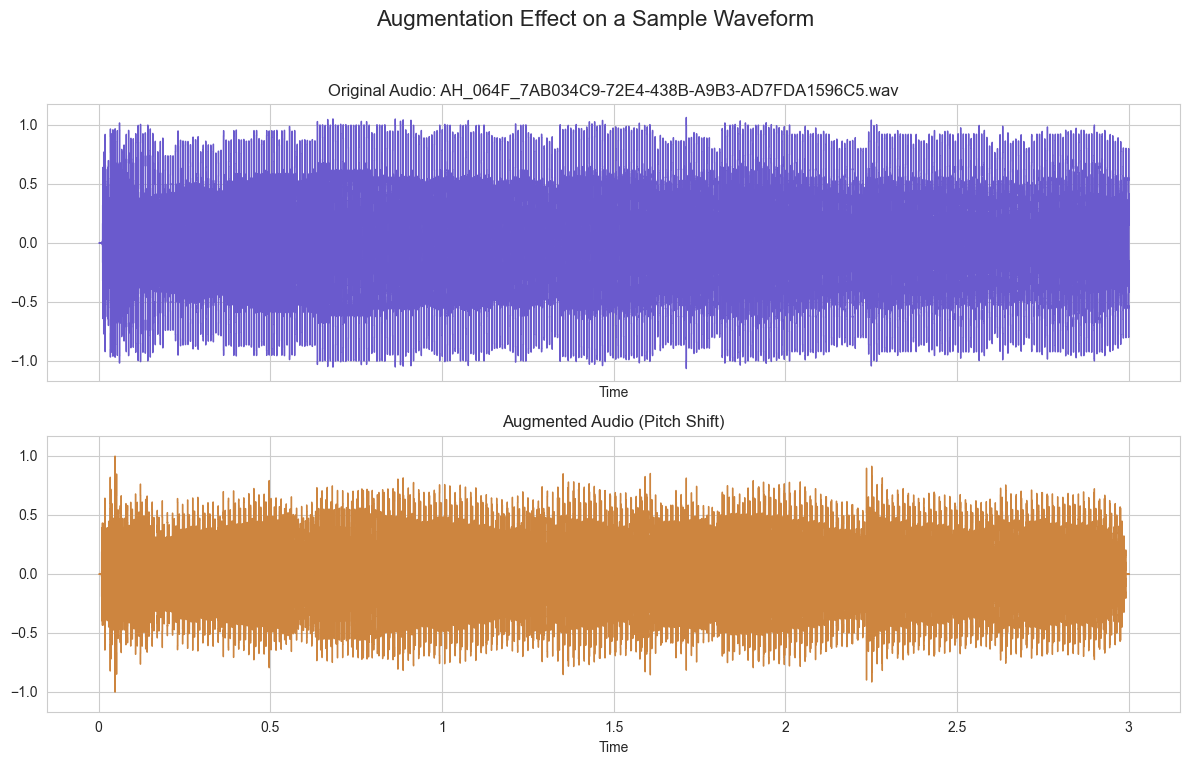

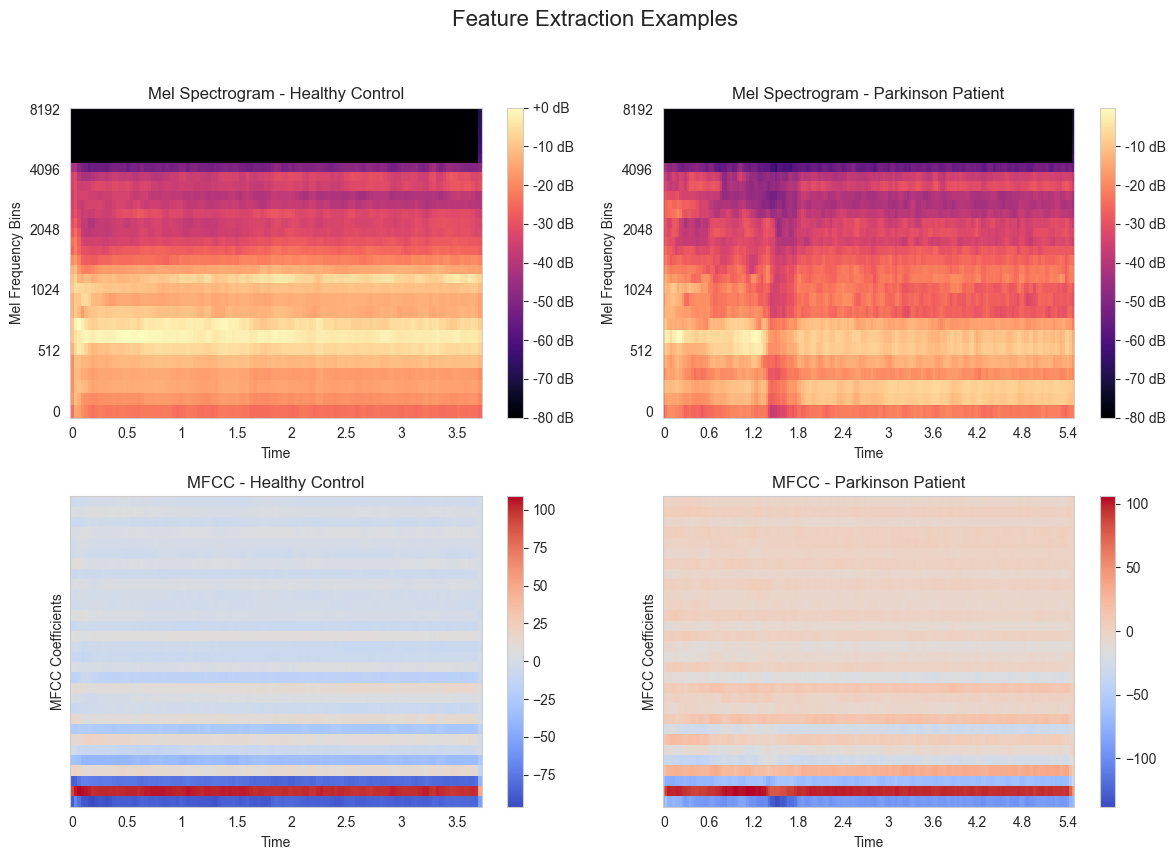

In [14]:
# =============================================================================
# --- Main Execution ---
# =============================================================================
if __name__ == '__main__':

    if DATASET == ITALIAN_DATASET:
        italian_metadata = pd.DataFrame()
        italian_metadata = load_italian_metadata(Italian_YHC_METADATA, Italian_EHC_METADATA, Italian_PD_METADATA)
        prepare_real_dataset(DATASET, DATASET_ROOT_PATH, ORIGINAL_DATA_PATH, VALID_FILE_PREFIXES, italian_metadata, MANIFEST_PATH)
    elif DATASET == NEUROVOZ_DATASET:
        prepare_real_dataset(DATASET, DATASET_ROOT_PATH, ORIGINAL_DATA_PATH, VALID_FILE_PREFIXES, Path(Neurovoz_MODIFIED_METADATA_FILE), MANIFEST_PATH)
    elif DATASET == UAMS_DATASET:
        prepare_real_dataset(DATASET, DATASET_ROOT_PATH, ORIGINAL_DATA_PATH, VALID_FILE_PREFIXES, Path(UAMS_METADATA_FILE), MANIFEST_PATH)
    elif DATASET == SYNTHETIC_DATASET:
        prepare_real_dataset(DATASET, DATASET_ROOT_PATH, ORIGINAL_DATA_PATH, VALID_FILE_PREFIXES, Path(Synthetic_METADATA_FILE), MANIFEST_PATH)
    elif DATASET == MPOWER_DATASET:
        prepare_real_dataset(DATASET, DATASET_ROOT_PATH, ORIGINAL_DATA_PATH, VALID_FILE_PREFIXES, Path(MPOWER_METADATA_FILE), MANIFEST_PATH)

    apply_augmentation(ORIGINAL_DATA_PATH, AUGMENTED_DATA_PATH)
    balance_data(ORIGINAL_DATA_PATH, AUGMENTED_DATA_PATH, BALANCED_DATA_PATH)
    all_features = extract_features(BALANCED_DATA_PATH, FEATURE_MODE, MANIFEST_PATH)
    save_features(FEATURES_OUTPUT_PATH, **all_features)

    # --- Generate Visualizations ---
    visualize_augmentation_effect(ORIGINAL_DATA_PATH, AUGMENTED_DATA_PATH, RESULTS_OUTPUT_PATH, MODE, FEATURE_MODE)
    visualize_features(BALANCED_DATA_PATH, RESULTS_OUTPUT_PATH, MODE, FEATURE_MODE)
    generate_and_save_summary(ORIGINAL_DATA_PATH, HEALTHY_CLASS, PARKINSON_CLASS, AUGMENTED_DATA_PATH, BALANCED_DATA_PATH, MODE, FEATURE_MODE)

